In [24]:
import pandas
pandas.set_option("display.max_rows", 50, "display.max_columns", 50)

import numpy
import pygsheets
import scipy.stats
import datetime

import matplotlib
import matplotlib.pyplot as mp
import seaborn

## colors

In [25]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

## import terminals data from sheet

In [26]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1tcS6Wd-Wp-LTDpLzFgJY_RSNDnbyubW3J_9HKIAys4A')

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df()

In [27]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Type1']!='Oil']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [28]:
mtpa_multiplier = 1/0.7352941863 # multiply by this to convert to bcm
#euro_multiplier = 1/1.14 # multiply USD by this to get Euro, should be same as currency conversions in Sheet

In [29]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(terms_df_orig['Country'])))
region_list = sorted(list(set(terms_df_orig['Region'])))

## table for exports

In [30]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                                   (terms_df_orig.Facility=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                                  (terms_df_orig.Facility=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

mtpa_by_region_export_df = mtpa_by_region_df.copy()

mtpa_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,406.07,39.36,445.43,12.29,455.11,89.20,0.0,1.50,0.0
Eurasia,113.40,21.10,134.50,14.42,16.36,29.10,0.0,0.00,0.0
Sub-Saharan Africa,51.42,13.92,65.34,34.10,31.79,34.32,0.0,0.00,0.0
Middle East and North Africa,63.60,1.07,64.67,22.00,87.75,136.94,0.0,10.40,7.8
SE Asia,19.50,5.80,25.30,1.50,12.55,66.65,0.0,0.00,30.1
Australia and New Zealand,20.10,0.00,20.10,7.20,45.80,87.60,0.0,0.00,0.0
Latin America and the Caribbean,5.37,0.00,5.37,0.00,16.60,19.75,0.0,0.45,0.0
East Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0
Europe,0.00,0.00,0.00,0.00,5.04,4.68,0.0,0.00,0.0
South Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0


## table for imports

In [31]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                                   (terms_df_orig.Facility=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                                  (terms_df_orig.Facility=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
# drop all all-zero columns
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

mtpa_by_region_import_df = mtpa_by_region_df.copy()
mtpa_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,149.76,91.25,241.01,25.80,54.49,447.10,0.0,1.5,0.0
Europe,133.91,31.18,165.09,21.50,83.94,175.15,0.0,0.0,3.0
South Asia,60.60,38.90,99.50,5.68,73.45,69.70,0.0,0.0,0.0
SE Asia,72.05,21.66,93.71,11.10,28.34,48.85,0.0,0.0,0.0
Latin America and the Caribbean,43.48,12.28,55.76,6.46,16.07,53.36,0.0,0.0,0.0
Sub-Saharan Africa,6.88,1.70,8.58,0.50,7.70,0.11,0.0,0.0,0.0
Australia and New Zealand,3.30,1.90,5.20,0.00,1.75,0.00,0.0,0.0,0.0
Middle East and North Africa,5.15,0.00,5.15,11.10,18.64,48.90,11.8,0.0,0.0
North America,0.05,0.00,0.05,0.00,268.42,94.30,3.0,53.8,17.3
Eurasia,0.00,0.00,0.00,0.00,0.00,12.20,0.0,0.0,0.0


## stacked bar charts for import/export capacity

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_12486/1303677211.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')


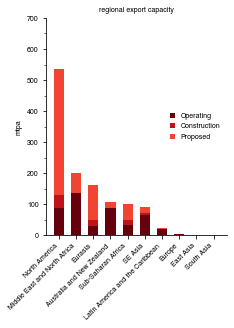

In [33]:
font_size = 7
ytop = 700
set_width=0.6

region_order = mtpa_by_region_export_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_export_df.loc[region_order,:]

fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=font_size)
ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')
ax.set_ylabel('mtpa', size=font_size)

ax.set_ylim(0, ytop)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax.set_title('regional export capacity', fontsize=font_size)

mp.savefig('saved-figures/regional-export-capacity.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/regional-export-capacity.pdf',
          bbox_inches='tight', 
          transparent=True)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_12486/3496407851.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')


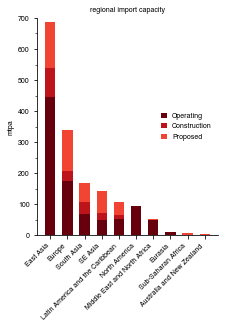

In [34]:
font_size = 7
ytop = 700
set_width=0.6

region_order = mtpa_by_region_import_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_import_df.loc[region_order,:]

fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.bar(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', width=set_width)
ax.bar(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      bottom=use_this_df['Operating'], width=set_width)
ax.bar(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      bottom=use_this_df[['Operating','Construction']].sum(axis=1), width=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=font_size)
ax.set_xticklabels(region_order, rotation=45, ha='right', va='top')
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_ylim(0, ytop)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax.set_title('regional import capacity', fontsize=font_size)

mp.savefig('saved-figures/regional-import-capacity.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/regional-import-capacity.pdf',
          bbox_inches='tight', 
          transparent=True)

## export and import capacity over time

## import

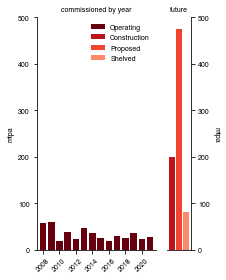

In [35]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                     (terms_df_orig.Facility=='Import')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                     (terms_df_orig.Facility=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 500
ytop2 = 500

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-import-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

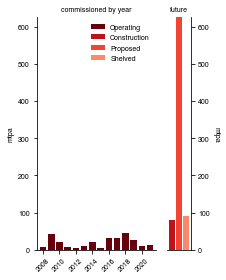

In [36]:
mtpa_started_sum = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                     (terms_df_orig.Facility=='Export')&
                                     (terms_df_orig.Status=='Operating')].groupby('StartYearEarliest')['CapacityInMtpa'].sum()
#terms_df_orig.groupby('StartYearEarliest')['CapacityInMtpa'].sum()

# indev pipelines = Proposed or Construction
mtpa_indev = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                     (terms_df_orig.Facility=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7

ytop = 625
ytop2 = 625

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(mtpa_started_sum.index.values[-15:-1], mtpa_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('mtpa', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, mtpa_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('mtpa', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

# redo fig above with big bars for each, not year-by-year

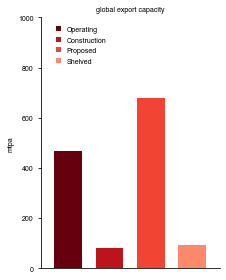

In [37]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                          (terms_df_orig.Facility=='Export')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-summed-bars.pdf', bbox_inches='tight', transparent=True)

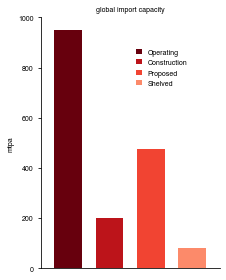

In [38]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                          (terms_df_orig.Facility=='Import')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 1000
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.5,0.9))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('global import capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-import-summed-bars.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-import-summed-bars.pdf', bbox_inches='tight', transparent=True)

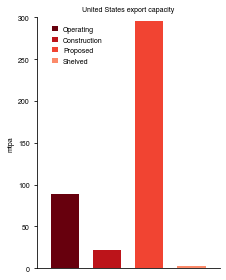

In [39]:
mtpa_summed_by_status = terms_df_orig.loc[(terms_df_orig.Type1=='LNG')&
                                          (terms_df_orig.Facility=='Export')&
                                          (terms_df_orig.Country=='United States')].groupby('Status')['CapacityInMtpa'].sum()

font_size = 7
ytop = 300
fig = mp.figure(figsize=(3.25,4))

ax = fig.add_subplot(111)

ax.set_xlim(0, 5)
ax.set_ylim(0, ytop)

ax.set_xlim(-.666,3.666)
xvals = [0,1,2,3]

ax.set_xticks([])
ax.set_ylabel('mtpa', size=font_size)
ax.tick_params(labelsize=font_size)

colors = [tracker_operating, tracker_construction, tracker_proposed, tracker_shelved]
status = ['Operating', 'Construction', 'Proposed', 'Shelved']
ax_list = []
for x,c,s in zip(xvals,colors,status):
    ax_list.append(ax.bar(x, mtpa_summed_by_status[s],
             color=c, label=s, width=0.666))

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.05,0.99))

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('United States export capacity', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-summed-bars-US-only.pdf', bbox_inches='tight', transparent=True)

# reproduce Clark Williams-Derry's plot

In [40]:
terms_df_cwd = terms_df_orig.loc[terms_df_orig.ExportFigureClarkWilliamsDerry=='yes']

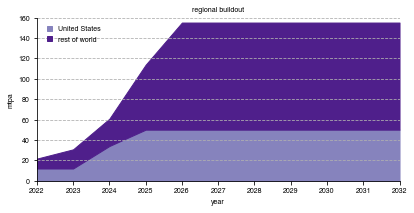

In [41]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_cwd_subset = terms_df_cwd.loc[(terms_df_cwd.StartYearEarliest==year_list[yr_idx])]
    mtpa_sum[yr_idx:] += terms_df_cwd_subset['CapacityInMtpa'].sum()
    
    terms_df_cwd_subset_usa = terms_df_cwd.loc[(terms_df_cwd.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_cwd.Country=='United States')]
    mtpa_sum_usa[yr_idx:] += terms_df_cwd_subset_usa['CapacityInMtpa'].sum()

font_size = 7
fig = mp.figure(figsize=(6.5,3))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,160)

sel_cmap = matplotlib.cm.get_cmap('Purples')
color_light = sel_cmap(0.6)
color_dark = sel_cmap(0.9)
ax.fill_between(year_list, mtpa_sum_usa, 0, label='United States', color=color_light)
ax.fill_between(year_list, mtpa_sum, mtpa_sum_usa, label='rest of world', color=color_dark)

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

mp.savefig('saved-figures/mtpa-export-usa-non-usa-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-usa-non-usa-timeseries.pdf', bbox_inches='tight', transparent=True)

## color coordinate by region

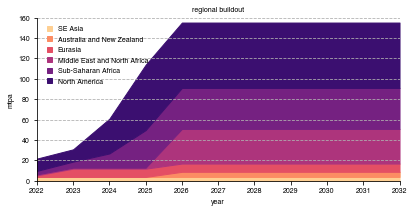

In [42]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)

for yr_idx in range(year_list.__len__()):
    terms_df_cwd_subset = terms_df_cwd.loc[terms_df_cwd.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_cwd_subset.groupby('Region')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

font_size = 7
fig = mp.figure(figsize=(6.5,3))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,160)

new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.9,0.2,new_region_list.__len__())]

for region_idx in range(new_region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        0, color=region_colors[region_idx], label=new_region_list[region_idx])
    else:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx]],
                        mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx-1]], 
                        color=region_colors[region_idx], label=new_region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

mp.savefig('saved-figures/mtpa-export-regional-timeseries.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-regional-timeseries.pdf', bbox_inches='tight', transparent=True)

# our version of Clark Williams-Derry's plot (using IGU data from 2022 LNG report)

In [43]:
terms_df_cwd2 = terms_df_orig.loc[terms_df_orig.IGUWorldLNGReportAppendix2=='yes']

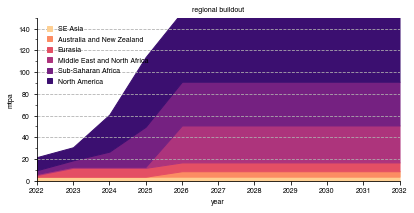

In [44]:
# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum_regional = pandas.DataFrame(0.0, columns=region_list, index=year_list)

for yr_idx in range(year_list.__len__()):
    terms_df_cwd_subset = terms_df_cwd.loc[terms_df_cwd.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum_regional.loc[year_list[yr_idx]] = terms_df_cwd_subset.groupby('Region')['CapacityInMtpa'].sum()

mtpa_sum_regional.replace(numpy.nan, 0.0, inplace=True)
mtpa_sum_regional_cumsum = mtpa_sum_regional.cumsum()
mtpa_sum_regional_cumsum.sort_values(axis='columns', by=year_list[-1], inplace=True)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum.cumsum(axis=1)
mtpa_sum_regional_cumsum_byregion = mtpa_sum_regional_cumsum_byregion.loc[:, (mtpa_sum_regional_cumsum_byregion != 0).any(axis=0)]

font_size = 7
fig = mp.figure(figsize=(6.5,3))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,150)

new_region_list = mtpa_sum_regional_cumsum_byregion.columns
sel_cmap = matplotlib.cm.get_cmap('magma')
region_colors = [sel_cmap(i) for i in numpy.linspace(0.9,0.2,new_region_list.__len__())]

for region_idx in range(new_region_list.__len__()):
    if region_idx==0:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[region_list[region_idx]],
                        0, color=region_colors[region_idx], label=new_region_list[region_idx])
    else:
        ax.fill_between(year_list, mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx]],
                        mtpa_sum_regional_cumsum_byregion[new_region_list[region_idx-1]], 
                        color=region_colors[region_idx], label=new_region_list[region_idx])

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/mtpa-export-regional-timeseries-IGU-Appendix2.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/mtpa-export-regional-timeseries-IGU-Appendix2.pdf', bbox_inches='tight', transparent=True)

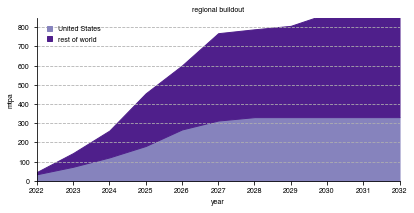

In [45]:
terms_df_export = terms_df_orig.loc[terms_df_orig.Facility=='Export']

# fill up new capacities as they come online
start_year = 2022
end_year = 2032
year_list = range(start_year, end_year+1, 1)
mtpa_sum = numpy.zeros(year_list.__len__())
mtpa_sum_usa = numpy.zeros(year_list.__len__())

for yr_idx in range(year_list.__len__()):
    terms_df_export_subset = terms_df_export.loc[terms_df_export.StartYearEarliest==year_list[yr_idx]]
    mtpa_sum[yr_idx:] += terms_df_export_subset['CapacityInMtpa'].sum()
    
    terms_df_export_subset_usa = terms_df_export.loc[(terms_df_export.StartYearEarliest==year_list[yr_idx])&
                                           (terms_df_export.Country=='United States')]
    mtpa_sum_usa[yr_idx:] += terms_df_export_subset_usa['CapacityInMtpa'].sum()

font_size = 7
fig = mp.figure(figsize=(6.5,3))

ax = fig.add_subplot(111)
ax.set_xlim(start_year, end_year)
ax.set_ylim(0,850)

sel_cmap = matplotlib.cm.get_cmap('Purples')
color_light = sel_cmap(0.6)
color_dark = sel_cmap(0.9)
ax.fill_between(year_list, mtpa_sum_usa, 0, label='United States', color=color_light)
ax.fill_between(year_list, mtpa_sum, mtpa_sum_usa, label='rest of world', color=color_dark)

ax.tick_params(labelsize=font_size)
ax.set_ylabel('mtpa', size=font_size)
ax.set_xlabel('year', size=font_size)
ax.yaxis.grid(linestyle='--')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax_h, ax_l = ax.get_legend_handles_labels()
ax.legend(ax_l, fontsize=font_size, frameon=False, handlelength=0.75, loc='upper left', bbox_to_anchor=(0.01,0.99))
ax.set_title('regional buildout', size=font_size)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# cost calculations

## create offshore and floating dfs

In [46]:
# insane outliers
# Ravenna - T068300
# Gorgon LNG (megaproject) - T068300
# Tanzania LNG Terminal trains 1, 2 - T026301, T026302
# Coral South FLNG Terminal - includes deep gas well construction - T025801
outlier_comboids = ['T068300','T068300','T026301','T026302','T025801']

In [47]:
terms_df_floating = terms_df_orig.loc[terms_df_orig.Floating=='yes']
terms_df_onshore = terms_df_orig.loc[terms_df_orig.Floating=='']

#terms_df_floating = terms_df_floating.loc[~terms_df_floating.ComboID.isin(outlier_comboids)]
#terms_df_onshore = terms_df_onshore.loc[~terms_df_onshore.ComboID.isin(outlier_comboids)]
terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

In [48]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion')]
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion')]

# count for Scott

how many per region do we currently have?

In [49]:
counts_df = pandas.DataFrame(index=region_list, columns=['Cost count', 'Total available'])
counts_df.loc[:,'Cost count'] = terms_df_floating_noexpansions.loc[(terms_df_floating_noexpansions.Facility=='Export')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['CostUSDPerMtpa'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
#
counts_df.loc[:,'Total available'] = terms_df_orig.loc[(terms_df_orig.Facility=='Export')&
                                                  (~terms_df_orig['UnitName'].str.contains('Expansion'))&
                                                    (terms_df_orig.Floating=='yes')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['TerminalName'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
counts_df

,Cost count,Total available
Australia and New Zealand,0.0,9.0
East Asia,0.0,0.0
Eurasia,1.0,1.0
Europe,0.0,0.0
Latin America and the Caribbean,0.0,3.0
Middle East and North Africa,0.0,4.0
North America,4.0,14.0
SE Asia,0.0,7.0
South Asia,0.0,0.0
Sub-Saharan Africa,4.0,9.0


In [50]:
counts_df = pandas.DataFrame(index=region_list, columns=['Cost count', 'Total available'])
counts_df.loc[:,'Cost count'] = terms_df_floating_noexpansions.loc[(terms_df_floating_noexpansions.Facility=='Import')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['CostUSDPerMtpa'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
#
counts_df.loc[:,'Total available'] = terms_df_orig.loc[(terms_df_orig.Facility=='Import')&
                                                  (~terms_df_orig['UnitName'].str.contains('Expansion'))&
                                                    (terms_df_orig.Floating=='yes')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['TerminalName'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
counts_df

,Cost count,Total available
Australia and New Zealand,3.0,5
East Asia,0.0,5
Eurasia,0.0,1
Europe,14.0,28
Latin America and the Caribbean,1.0,30
Middle East and North Africa,0.0,14
North America,0.0,9
SE Asia,4.0,23
South Asia,6.0,23
Sub-Saharan Africa,1.0,12


In [51]:
counts_df = pandas.DataFrame(index=region_list, columns=['Cost count', 'Total available'])
counts_df.loc[:,'Cost count'] = terms_df_onshore_noexpansions.loc[(terms_df_onshore_noexpansions.Facility=='Import')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['CostUSDPerMtpa'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
#
counts_df.loc[:,'Total available'] = terms_df_orig.loc[(terms_df_orig.Facility=='Import')&
                                                  (~terms_df_orig['UnitName'].str.contains('Expansion'))&
                                                    (terms_df_orig.Floating=='')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['TerminalName'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
counts_df

,Cost count,Total available
Australia and New Zealand,1.0,2
East Asia,15.0,145
Eurasia,0.0,2
Europe,15.0,67
Latin America and the Caribbean,5.0,15
Middle East and North Africa,2.0,6
North America,2.0,49
SE Asia,11.0,54
South Asia,5.0,22
Sub-Saharan Africa,0.0,6


In [62]:
counts_df = pandas.DataFrame(index=region_list, columns=['Cost count', 'Total available'])
counts_df.loc[:,'Cost count'] = terms_df_onshore_noexpansions.loc[(terms_df_onshore_noexpansions.Facility=='Export')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['CostUSDPerMtpa'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
#
counts_df.loc[:,'Total available'] = terms_df_orig.loc[(terms_df_orig.Facility=='Export')&
                                                  (~terms_df_orig['UnitName'].str.contains('Expansion'))&
                                                    (terms_df_orig.Floating=='')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['TerminalName'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
counts_df

,Cost count,Total available
Australia and New Zealand,4.0,12.0
East Asia,0.0,0.0
Eurasia,1.0,19.0
Europe,0.0,7.0
Latin America and the Caribbean,3.0,7.0
Middle East and North Africa,6.0,23.0
North America,11.0,80.0
SE Asia,1.0,13.0
South Asia,0.0,0.0
Sub-Saharan Africa,5.0,14.0


In [63]:
counts_df = pandas.DataFrame(index=region_list, columns=['Cost count'])
counts_df.loc[:,'Cost count'] = terms_df_onshore_noexpansions.loc[(terms_df_onshore_noexpansions.Facility=='Export')
                                  ].drop_duplicates(subset=['TerminalName'], keep='first').groupby('Region')['CostUSDPerMtpa'].count()
counts_df.replace(numpy.nan, 0, inplace=True)
counts_df

,Cost count
Australia and New Zealand,4.0
East Asia,0.0
Eurasia,1.0
Europe,0.0
Latin America and the Caribbean,3.0
Middle East and North Africa,6.0
North America,11.0
SE Asia,1.0
South Asia,0.0
Sub-Saharan Africa,5.0


## import

### count for Scott

In [49]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions.Facility=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Tema FSRU Terminal,Ghana,Construction,https://www.gem.wiki/Tema_FSRU_Terminal,205882352.900000
Newcastle FSRU Terminal,Australia,Proposed,https://www.gem.wiki/Newcastle_FSRU_Terminal,406410000.000000
Eagle FLNG Terminal,Albania,Cancelled,https://www.gem.wiki/Eagle_FLNG_Terminal,140740740.700000
Krk LNG Terminal,Croatia,Operating,https://www.gem.wiki/Hrvatska_LNG_Terminal,124887381.400000
Krk LNG Terminal,Croatia,Proposed,https://www.gem.wiki/Krk_LNG_Terminal,232075478.300000
Cyprus LNG Terminal,Cyprus,Construction,https://www.gem.wiki/Cyprus_LNG_Terminal,592800000.000000
Wilhelmshaven FSRU Terminal,Germany,Construction,https://www.gem.wiki/Wilhelmshaven_LNG_Terminal,93023991.300000
Toscana LNG Terminal,Italy,Operating,https://www.gem.wiki/Toscana_LNG_Terminal,223928571.400000
Klaipeda LNG Terminal,Lithuania,Operating,https://www.gem.wiki/Klaipeda_LNG_Terminal,39590913.800000
Port Meridian FLNG Terminal,United Kingdom,Cancelled,https://www.gem.wiki/Port_Meridian_FLNG_Terminal,77898916.700000


In [50]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions.Facility=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Jorf Lasfar LNG Terminal,Morocco,Proposed,https://www.gem.wiki/Jorf_Lasfar_LNG_Terminal,874285632.700000
Kerewalapitiya LNG Terminal,Sri Lanka,Shelved,https://www.gem.wiki/Kerewalapitiya_LNG_Terminal,92592592.600000
Taichung LNG Terminal,Taiwan,Operating,https://www.gem.wiki/Taichung_LNG_Terminal,357000000.000000
22/05/16,Vietnam,Proposed,https://www.gem.wiki/Son_My_LNG_Terminal,388888888.900000
Wenzhou LNG Terminal,China,Construction,https://www.gem.wiki/Wenzhou_LNG_Terminal,477120000.000000
Paldiski LNG Terminal,Estonia,Proposed,https://www.gem.wiki/Paldiski_LNG_Terminal,253333333.300000
Haldia LNG Terminal,India,Shelved,https://www.gem.wiki/Haldia_LNG_Terminal,195000000.000000
Tallinn LNG Terminal,Estonia,Shelved,https://www.gem.wiki/Tallinn_LNG_Terminal,105555555.600000
Pori LNG Terminal,Finland,Operating,https://www.gem.wiki/Pori_LNG_Terminal,880000000.000000
Brunsbüttel LNG Terminal,Germany,Proposed,https://www.gem.wiki/Hamburg_LNG_Terminal,193799981.900000


## export

In [51]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions.Facility=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Cedar FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Cedar_FLNG_Terminal,800000000.000000
Ksi Lisims LNG Terminal,Canada,Proposed,https://www.gem.wiki/Ksi_Lisims_LNG_Terminal,833333333.300000


In [52]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions.Facility=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,547474747.500000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,547474747.500000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,547474747.500000
G2 LNG Terminal,United States,Proposed,https://www.gem.wiki/G2_LNG_Terminal,846153846.200000


In [53]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions.Facility=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions.Facility=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions.Facility=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions.Facility=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions.Facility=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_error = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions.Facility=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions.Facility=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions.Facility=='Import')][['CostUSDPerMtpa']].std().values

In [54]:
cost_onshore_export

array([6.45151769e+08])

In [55]:
cost_floating_export

array([6.61111111e+08])

In [56]:
cost_onshore_import

array([2.78572072e+08])

In [57]:
cost_floating_import

array([1.54436613e+08])

## now calculate the import terminal costs

## calculate how much export/import capacity data we have

In [92]:
terms_df_costs_exist = terms_df_orig.loc[~terms_df_orig.CostUSDPerMtpa.isnull()]
terms_df_costs_exist.to_excel('available-cost-data.xlsx', index=False)

In [87]:
#% of import terms that we have a capacity for?
terms_df_orig.loc[(terms_df_orig['Facility']=='Import')].shape)
print(510/587 * 100)

(586, 74)
(512, 74)
86.88245315161839


In [58]:
#% of import terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Facility']=='Import')].shape)
print(terms_df_orig.loc[(terms_df_orig['Facility']=='Import')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(510/587 * 100)

(586, 74)
(512, 74)
86.88245315161839


In [59]:
#% of export terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Facility']=='Export')].shape)
print(terms_df_orig.loc[(terms_df_orig['Facility']=='Export')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(542/560 * 100)

(566, 74)
(548, 74)
96.78571428571429


In [60]:
terms_df_import = terms_df_orig.loc[terms_df_orig['Facility']=='Import']
#    (terms_df_orig['Status'].isin(['Proposed','Construction']))&
#    (terms_df_orig['Facility']=='Import')]

terms_df_import.loc[:,'CostUSDTotal'] = numpy.nan

# do for floating
terms_df_import.loc[
    (terms_df_import['Floating']=='yes'), 'CostUSDTotal'] = terms_df_import.loc[
    (terms_df_import['Floating']=='yes'), 'CapacityInMtpa'] * cost_floating_import

# now do for onshore
terms_df_import.loc[
    (terms_df_import['Floating']!='yes'), 'CostUSDTotal'] = terms_df_import.loc[
    (terms_df_import['Floating']!='yes'), 'CapacityInMtpa'] * cost_onshore_import

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostEstUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostEstUSD']

/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## and calculate export terminal costs

In [61]:
terms_df_export = terms_df_orig.loc[terms_df_orig['Facility']=='Export']
#    (terms_df_orig['Status'].isin(['Proposed','Construction']))&
#    (terms_df_orig['Facility']=='Export')]

terms_df_export.loc[:,'CostUSDTotal'] = numpy.nan

# do for floating
terms_df_export.loc[
    (terms_df_export['Floating']=='yes'), 'CostUSDTotal'] = terms_df_export.loc[
    (terms_df_export['Floating']=='yes'), 'CapacityInMtpa'] * cost_floating_export

# now do for onshore
terms_df_export.loc[
    (terms_df_export['Floating']!='yes'), 'CostUSDTotal'] = terms_df_export.loc[
    (terms_df_export['Floating']!='yes'), 'CapacityInMtpa'] * cost_onshore_export

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostEstUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostEstUSD']

## import terminal costs table

In [62]:
#mtpa by country
cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_import_df.index:
    cost_by_region_import_df.drop(index='Total', inplace=True)   
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

else:
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

# total
if 'Total' in cost_by_country_import_df.index:
    cost_by_country_import_df.drop(index='Total', inplace=True)   
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

else:
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,41.029508,25.960193,66.989701,6.146313,14.806986,124.508473,0.000000,0.417858,0.000000
Europe,29.172530,3.476284,32.648813,4.618471,20.449793,47.243973,0.000000,0.000000,0.463310
SE Asia,24.232260,3.816848,28.049107,4.001927,5.730991,11.206225,0.000000,0.000000,0.000000
South Asia,11.904326,8.028839,19.933166,0.986327,16.743262,16.660666,0.000000,0.000000,0.000000
Latin America and the Caribbean,8.315010,1.896482,10.211492,0.997661,4.042179,9.411335,0.000000,0.000000,0.000000
Middle East and North Africa,4.500000,0.000000,4.500000,1.714246,5.192583,9.798802,1.822352,0.000000,0.000000
Sub-Saharan Africa,1.535306,0.350000,1.885306,0.077218,1.189162,0.016988,0.000000,0.000000,0.000000
Australia and New Zealand,0.716910,0.172500,0.889410,0.000000,0.487501,0.000000,0.000000,0.000000,0.000000
Eurasia,0.000000,0.000000,0.000000,0.000000,0.000000,3.063414,0.000000,0.000000,0.000000
North America,0.000000,0.000000,0.000000,0.000000,68.008933,26.132797,0.463310,14.987177,4.819297


In [63]:
#mtpa by country
cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_export_df.index:
    cost_by_region_export_df.drop(index='Total', inplace=True)   
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

else:
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

# total
if 'Total' in cost_by_country_export_df.index:
    cost_by_country_export_df.drop(index='Total', inplace=True)   
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

else:
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df/1e9

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,292.109816,30.690253,322.800069,11.206446,295.253003,57.547538,0.0,0.967728,0.000000
Eurasia,75.902209,16.454701,92.356910,14.987085,10.574792,18.773916,0.0,0.000000,0.000000
Sub-Saharan Africa,73.317302,12.258105,85.575407,24.793333,20.539538,22.100887,0.0,0.000000,0.000000
Middle East and North Africa,55.749013,0.690312,56.439325,14.193339,58.184389,88.347083,0.0,6.709578,5.032184
SE Asia,36.697395,3.741880,40.439275,0.967728,8.249864,56.687696,0.0,0.000000,19.419068
Australia and New Zealand,15.523728,0.000000,15.523728,6.854789,29.817664,108.359998,0.0,0.000000,0.000000
Latin America and the Caribbean,3.464465,0.000000,3.464465,0.000000,10.760589,12.741747,0.0,0.297500,0.000000
East Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Europe,0.000000,0.000000,0.000000,0.000000,3.251565,3.019310,0.0,0.000000,0.000000
South Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


## costs of CWD projects

In [64]:
terms_df_export.loc[terms_df_export.ExportFigureClarkWilliamsDerry=='yes']['CostUSDTotal'].sum()/1e9

135.68480743041712

In [65]:
terms_df_orig.loc[terms_df_orig.ExportFigureClarkWilliamsDerry=='yes']['CostEstUSD'].sum()/1e9

114.149999999

In [66]:
terms_df_import.loc[terms_df_import.ExportFigureClarkWilliamsDerry=='yes']['CostUSDTotal'].sum()/1e9

0.0

# pie charts with costs, mtpa

## import

In [67]:
cost_by_region_import_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,4.102951e+10,2.596019e+10,6.698970e+10,6.146313e+09,1.480699e+10,1.245085e+11,0.000000e+00,4.178581e+08,0.000000e+00
Europe,2.917253e+10,3.476284e+09,3.264881e+10,4.618471e+09,2.044979e+10,4.724397e+10,0.000000e+00,0.000000e+00,4.633098e+08
SE Asia,2.423226e+10,3.816848e+09,2.804911e+10,4.001927e+09,5.730991e+09,1.120622e+10,0.000000e+00,0.000000e+00,0.000000e+00
South Asia,1.190433e+10,8.028839e+09,1.993317e+10,9.863267e+08,1.674326e+10,1.666067e+10,0.000000e+00,0.000000e+00,0.000000e+00
Latin America and the Caribbean,8.315010e+09,1.896482e+09,1.021149e+10,9.976605e+08,4.042179e+09,9.411335e+09,0.000000e+00,0.000000e+00,0.000000e+00
Middle East and North Africa,4.500000e+09,0.000000e+00,4.500000e+09,1.714246e+09,5.192583e+09,9.798802e+09,1.822352e+09,0.000000e+00,0.000000e+00
Sub-Saharan Africa,1.535306e+09,3.500000e+08,1.885306e+09,7.721831e+07,1.189162e+09,1.698803e+07,0.000000e+00,0.000000e+00,0.000000e+00
Australia and New Zealand,7.169100e+08,1.725000e+08,8.894100e+08,0.000000e+00,4.875011e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Eurasia,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.063414e+09,0.000000e+00,0.000000e+00,0.000000e+00
North America,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.800893e+10,2.613280e+10,4.633098e+08,1.498718e+10,4.819297e+09


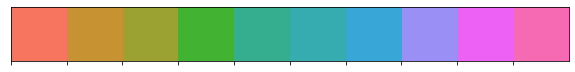

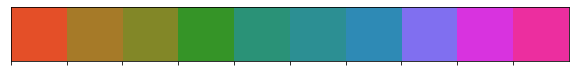

In [84]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, h=0.05, s=0.9, l=0.65))
seaborn.palplot(seaborn.husl_palette(10, h=0.05, l=0.55))

cmap_light = seaborn.husl_palette(10, h=0.05, l=0.6, s=0.9, as_cmap=True)
cmap_dark = seaborn.husl_palette(10, h=0.05, l=0.4, as_cmap=True)

##### mtpa_by_region_import_df

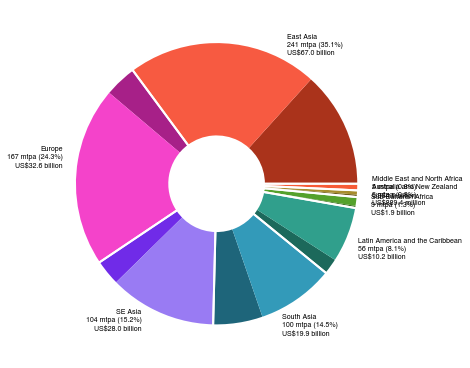

In [85]:
font_size=7

fig = mp.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(111)

nwedges = 8 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_import_df.index[:nwedges]
pie_vals = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].values

pie_labels = mtpa_by_region_import_df.index
pie_labels_mtpa = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_import_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/mtpa-import-pie-graph-region-switch-dark-light.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/mtpa-import-pie-graph-region-switch-dark-light.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)

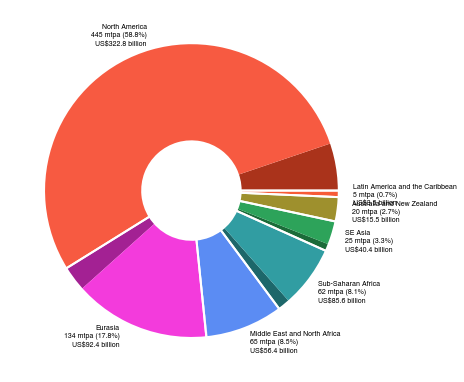

In [86]:
font_size=7

fig = mp.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(111)

nwedges = 7 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_export_df.index[:nwedges]

pie_vals = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].values
pie_labels = mtpa_by_region_export_df.index
pie_labels_mtpa = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_export_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/mtpa-export-pie-graph-region-switch-dark-light.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/mtpa-export-pie-graph-region-switch-dark-light.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)